## Fine-tuning DETR on a custom dataset for object detection

this is a copy of [notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb#scrollTo=AVcRLJp2dl0L)

## Set up environment

In [3]:
!pip install -q transformers timm pytorch-lightning scipy

## Download + preprocess data

Here we download the balloon dataset, hosted on Github.

In [5]:
!gdown "1t8qFwAAS-xICZ6p6NuUU987zPcocO_Zg"

Downloading...
From: https://drive.google.com/uc?id=1t8qFwAAS-xICZ6p6NuUU987zPcocO_Zg
To: /workspace/dataset.zip
100%|████████████████████████████████████████| 180M/180M [00:04<00:00, 42.3MB/s]


## Create PyTorch dataset + dataloaders

In [1]:
import json
root = 'dataset'
# load
ann = json.load(open(root + '/result.table-column.json', 'r'))
eval_ann = ann.copy()
eval_ann['images'] = ann['images'][:25]
json.dump(eval_ann, open(root+'/eval.json', 'w'))

train_ann = ann.copy()
train_ann['images'] = ann['images'][25:]
json.dump(train_ann, open(root+'/train.json', 'w'))

In [2]:
import cv2
def add_noise(image, prop):
    fmask=np.random.rand(*image.shape[:2])
    mask = np.where(fmask<prop)
    image[mask] = 0
    return image

def get_pepper(image):
    noise = image.copy()
    noise.fill(255)
    
    original_h,original_w=image.shape[:2]
    nit = 5
    for i in range(nit):
        div = (nit-i)*2
        h=original_h//div
        w=original_w//div
        noise = cv2.resize(noise, (w,h))
        noise = add_noise(noise, prop=0.0005)
    noise = cv2.resize(noise, (original_w,original_h))
    ret,thes = cv2.threshold(noise,150,255,cv2.THRESH_BINARY)
    return thes

def mask_noise(image):
    noise = image.copy()
    noise.fill(250)
    
    original_h,original_w=image.shape[:2]
    nit = 5
    for i in range(nit):
        div = (nit-i)*3
        h=original_h//div
        w=original_w//div
        noise = cv2.resize(noise, (w,h))
        noise = add_noise(noise,0.025*div)
    noise = cv2.resize(noise, (original_w,original_h))
    ret,thes = cv2.threshold(noise,110,255,cv2.THRESH_BINARY)
    return thes

In [4]:
import torchvision
from torchvision.datasets import CocoDetection
import os

class TableCocoDetection(CocoDetection):
    def __init__(self, feature_extractor, ann_fname,):
        img_folder = root
        ann_file = os.path.join(img_folder, ann_fname)
        assert os.path.isfile(ann_file)
        super(TableCocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        pil_img, target = super(TableCocoDetection, self).__getitem__(idx)
        
        img_cv=np.array(pil_img)
        mnoise = mask_noise(img_cv)
        new_img = cv2.add(mnoise,img_cv)
        wnoise_img = cv2.bitwise_and(new_img,get_pepper(img_cv))
        img = Image.fromarray(wnoise_img)
        
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [5]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = TableCocoDetection(
    ann_fname='train.json',
    feature_extractor=feature_extractor,
    )
eval_dataset = TableCocoDetection(
    ann_fname='eval.json',
    feature_extractor=feature_extractor,
    )

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Let's see the categories in our dataset

As you can see, this dataset is tiny:

In [6]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 343


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

Image n°367


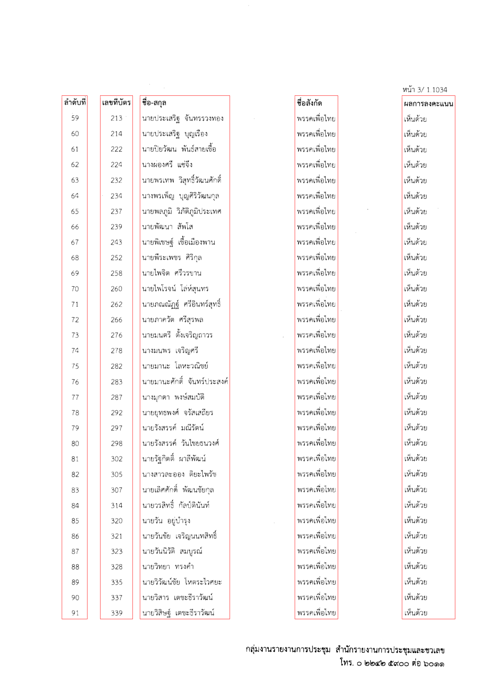

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(root, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image.resize((500,700))

Next, let's create corresponding dataloaders. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

Let's verify the keys of a single batch:

In [9]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the `pixel_values`, and check the `target`::

In [10]:
pixel_values, target = train_dataset[0]

In [11]:
pixel_values.shape

torch.Size([3, 1124, 800])

In [12]:
print(target)

{'boxes': tensor([[0.1522, 0.5114, 0.0507, 0.7473],
        [0.2350, 0.5114, 0.0641, 0.7473],
        [0.3762, 0.5114, 0.1903, 0.7473],
        [0.6375, 0.5114, 0.0908, 0.7473],
        [0.8588, 0.5114, 0.1061, 0.7473]]), 'class_labels': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([25]), 'area': tensor([ 34090.6055,  43061.8164, 127839.7656,  61004.2383,  71321.1328]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'orig_size': tensor([2105, 1498]), 'size': tensor([1124,  800])}


## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters). 

You can of course just train the model in native PyTorch as an alternative.

In [13]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("nielsr/detr-table-detection", num_labels=len(id2label), ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
       
       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     

        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return eval_dataloader

As PyTorch Lightning by default logs to Tensorboard, let's start it:

Here we define the model, and verify the outputs.

In [14]:
model = Detr(lr=1e-5, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at nielsr/detr-table-detection were not used when initializing DetrForObjectDetection: ['model.encoder.layernorm.weight', 'model.encoder.layernorm.bias']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at nielsr/detr-table-detection and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([3, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_cl

The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension. 

In [15]:
# outputs.logits.shape

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. You can refresh Tensorboard above to check the various losses.

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, max_epochs=15, gradient_clip_val=0.1)
trainer.fit(model)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 28.8 M
-------------------------------------------------
28.6 M    Trainable params
156 K     Non-trainable params
28.8 M    Total params
115.202   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:99: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Training: 0it [00:00, ?it/s]

## Evaluate the model

Finally, we evaluate the model on the validation set. The original DETR repo has some nice evaluation tools that we will use.

They are based on the `CocoEvaluator` class from torchvision, which in turn is based on [this](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py).

Let's first load the ground truth COCO dataset:

In [ ]:
!git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(eval_dataset) # this is actually just calling the coco attribute

Let's run the evaluation:

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(eval_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()

        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = eval_dataset[19]

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
image_id = target['image_id'].item()
image = eval_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(root, image['file_name']))

visualize_predictions(image, outputs)

In [ ]:
!huggingface-cli login

Config label

In [ ]:
model.model.config.id2label = {k: v['name'] for k, v in train_dataset.coco.cats.items()}
model.model.config.label2id = {v['name']: k for k, v in train_dataset.coco.cats.items()}

In [ ]:
model.model.push_to_hub('napatswift/paliament-vote-table-detection', )